# Distance to nearest geometry

Example: distance to nearest coast in NZ

In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt 
import rasterio.plot 
import rasterio.transform
import rasterio.features
import numpy as np

In [2]:
from helpers import nz, src_nz_elev

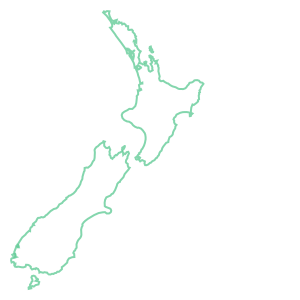

In [3]:
coastline = nz.dissolve().to_crs(src_nz_elev.crs).boundary.iloc[0]
coastline

In [5]:
factor = 0.2 
r = src_nz_elev.read(1, 
                    out_shape=(
                        int(src_nz_elev.height * factor), 
                        int(src_nz_elev.width * factor)
                    ),
                    resampling=rasterio.enums.Resampling.average)
new_transform = (src_nz_elev.transform * 
                 src_nz_elev.transform.scale(
                     (src_nz_elev.width / r.shape[1]), 
                     (src_nz_elev.height / r.shape[0])
                 )
                )

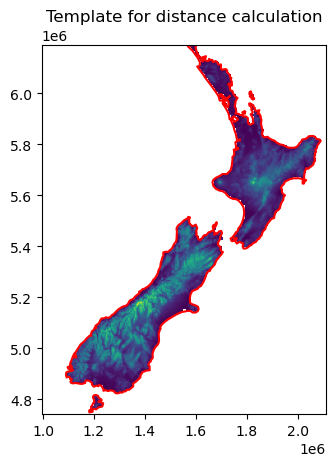

In [7]:
fig, ax = plt.subplots()
rasterio.plot.show(r, transform=new_transform, ax=ax)
gpd.GeoSeries(coastline).plot(ax=ax, ec='r')
ax.set_title("Template for distance calculation");

In [8]:
height = r.shape[0]
width = r.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
x, y = rasterio.transform.xy(new_transform, rows, cols)
x = np.array(x).flatten() 
y = np.array(y).flatten()
z = r.flatten() 
x = x[~np.isnan(z)]
y = y[~np.isnan(z)]
geom = gpd.points_from_xy(x, y, crs=nz.crs)
geom = list(geom)
geom[:5]

[<POINT (1572956.546 6189460.927)>,
 <POINT (1577956.546 6189460.927)>,
 <POINT (1582956.546 6189460.927)>,
 <POINT (1587956.546 6189460.927)>,
 <POINT (1592956.546 6189460.927)>]

In [10]:
distances = [(i, i.distance(coastline)) for i in geom] 
distances[0]

(<POINT (1572956.546 6189460.927)>, 826.7523956221047)

In [12]:
image = rasterio.features.rasterize(
    distances, 
    out_shape=r.shape, 
    dtype=float, 
    transform=new_transform, 
    fill=np.nan
)
image

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

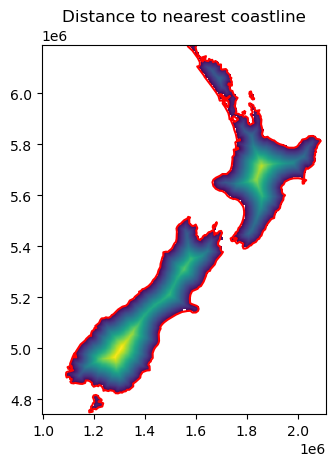

In [16]:
_, ax = plt.subplots() 
rasterio.plot.show(image, transform=new_transform, ax=ax)
gpd.GeoSeries(coastline).plot(ax=ax, ec='r')
ax.set_title("Distance to nearest coastline");